# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Это домашнее задание проходит в формате peer-review. Это означает, что его будут проверять ваши однокурсники. Поэтому пишите разборчивый код, добавляйте комментарии и пишите выводы после проделанной работы.

В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.6 MB/s eta 0:00:00


Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [5]:
# Загрузим датасет
dataset = load_dataset('imdb')

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [6]:
print(dataset['train'][0])
print(len(dataset['train']))
print(len(dataset['test']))


{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

In [7]:
word_threshold = 32
sentences = []
for section in dataset['train']:
    for sent in sent_tokenize(section['text']):
        words = word_tokenize(sent)
        if len(words) < word_threshold:
            sentences.append(words)

# Получить отдельные предложения и поместить их в sentences

In [8]:
print(sentences[0])
print("Всего предложений:", len(sentences))

['I', 'rented', 'I', 'AM', 'CURIOUS-YELLOW', 'from', 'my', 'video', 'store', 'because', 'of', 'all', 'the', 'controversy', 'that', 'surrounded', 'it', 'when', 'it', 'was', 'first', 'released', 'in', '1967', '.']
Всего предложений: 198801


Посчитаем для каждого слова его встречаемость.

In [9]:
words = Counter()

# Расчет встречаемости слов

for sentence in tqdm(sentences):
    for word in sentence:
        words[word] += 1

  0%|          | 0/198801 [00:00<?, ?it/s]

In [10]:
print(words['rented'])

221


Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [11]:
print(words)

Counter({'.': 170189, 'the': 126124, ',': 114121, 'a': 71655, 'and': 68621, 'of': 62048, 'to': 59630, 'is': 56695, 'I': 46474, 'it': 39499, 'in': 38242, 'this': 32565, 'that': 31342, "'s": 29190, 'was': 27435, 'The': 24587, 'movie': 24248, 'for': 19693, 'film': 19124, 'with': 18608, '!': 18535, '/': 18048, 'as': 18006, '>': 17992, '<': 17967, 'br': 17940, "n't": 17661, 'but': 15649, 'you': 15526, 'are': 14874, 'on': 14774, 'not': 14539, 'have': 14225, '``': 14214, "''": 13624, 'be': 12899, '?': 12435, 'It': 12203, ')': 11738, 'one': 11582, 'his': 11463, '(': 11243, 'he': 10937, 'all': 10200, 'at': 9989, 'This': 9954, 'like': 9346, 'an': 9344, 'they': 9339, 'by': 8814, 'just': 8463, 'from': 8395, 'about': 8363, 'so': 8311, 'do': 8237, 'has': 8230, 'who': 7820, 'out': 7809, 'her': 7726, 'good': 7557, 'or': 7433, 'very': 6961, 'more': 6539, 'would': 6442, 'some': 6391, 'really': 6096, 'what': 6078, 'can': 6021, 'time': 5898, 'there': 5815, 'were': 5708, 'my': 5666, 'me': 5635, 'see': 5634

In [12]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
vocab_size = 40000
for i, name in enumerate(words.keys()):
    if i >= vocab_size:
        break
    vocab.add(name)

In [13]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [14]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [15]:
word2ind = {word: i for i, word in enumerate(vocab)}
ind2word = {i: word for word, i in word2ind.items()}

In [16]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [word2ind.get(word, self.unk_id) for word in self.data[idx]]
        tokenized_sentence += [self.eos_id]
        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [17]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [18]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)
eval_sentences, test_sentences = train_test_split(sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

In [19]:
#dataset_test test
print(train_sentences[0])
print(train_dataset[0])

if False:
    for word, indx in zip(['<bos>'] + train_sentences[0]+['eos'], train_dataset[0]):
        print(word, indx)
# если поставить True то можно убедиться, что у одинаковых слов одинаковые индексы (and - 28098)

['I', "'ll", 'never', 'watch', 'it', 'again', '!']
[9419, 20402, 11022, 38250, 33424, 15600, 36298, 24011, 3265]


## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [20]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in dataloader:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [21]:
def train_model(model, optimizer, criterion,train_dataloader, eval_dataloader, num_epoch=25):
    losses = []
    perplexities = []
    model.train()

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for batch in tqdm(train_dataloader, desc=f'Training epoch {epoch}:'):
            optimizer.zero_grad()
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(
                logits, batch['target_ids'].flatten())
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        losses.append(sum(epoch_losses) / len(epoch_losses))
        perplexities.append(evaluate(model, criterion, eval_dataloader))
    return losses, perplexities

In [22]:
def draw_loss_and_perplex(losses, perplexities):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(np.arange(len(losses)), losses)
    plt.title('Losses')
    plt.xlabel("epoch")

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(len(perplexities)), perplexities)
    plt.title('Perplexity')
    plt.xlabel("epoch")

    plt.tight_layout()  # Для корректного отображения подписей осей
    plt.show()

In [23]:
def generate_sequence(model, starting_seq: str, max_seq_len: int = 128) -> str:
    device = 'cpu'
    model = model.to(device)
    input_ids = [word2ind['<bos>']] + [
        word2ind.get(char, word2ind['<unk>']) for char in starting_seq]
    input_ids = torch.LongTensor(input_ids).to(device)

    model.eval()
    with torch.no_grad():
        for i in range(max_seq_len):
            next_char_distribution = model(input_ids)[-1]
            next_char = next_char_distribution.squeeze().argmax()
            input_ids = torch.cat([input_ids, next_char.unsqueeze(0)])

            if next_char.item() == word2ind['<eos>']:
                break

    words = ' '.join([ind2word[idx.item()] for idx in input_ids])

    return words

In [24]:
def train_and_plot(model, optimizer, criterion, train_dataloader, eval_dataloader, num_epoch=25):
    model = model.to('cuda')
    losses, perplexities= train_model(model, optimizer, criterion,train_dataloader, eval_dataloader, num_epoch)
    draw_loss_and_perplex(losses, perplexities)
    print('min perplexities:', min(perplexities))


In [25]:
def generate_some_examples(model, opening_seqs=None):
    # lets generate some examples
    model.eval()
    if opening_seqs is None:
       opening_seqs = [['This', 'film', 'is'],
                        ['It', 'was'],
                        ['The', 'relationship', 'between']]
    for starting_seq in opening_seqs:
        print('First few words:', starting_seq)
        print('\t',generate_sequence(model, starting_seq))

### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её.

In [ ]:
class GRU_LM(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch) -> torch.Tensor:
        '''
        [batch_size, seq_len, hidden_dim]
        [batch_size, seq_len, hidden_dim]
        [batch_size, seq_len, hidden_dim]
        [batch_size, seq_len, vocab_size]
        '''
        embeddings = self.embedding(input_batch)
        output, _ = self.rnn(embeddings)
        output = self.dropout(self.linear(self.non_lin(output)))
        projection = self.projection(self.non_lin(output))

        return projection

In [ ]:
model = GRU_LM(hidden_dim=256, vocab_size=len(vocab)).to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])


Training epoch 0::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 10::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 11::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 12::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 13::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 14::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 15::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 16::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 17::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 18::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 19::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 20::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 21::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 22::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 23::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 24::   0%|          | 0/1243 [00:00<?, ?it/s]

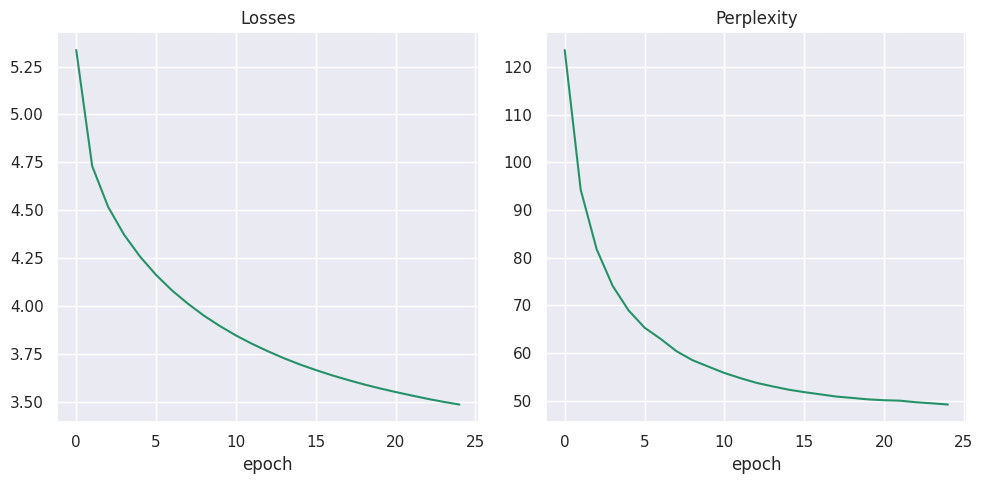

In [ ]:

train_and_plot(model=model, optimizer=optimizer, criterion=criterion,
               train_dataloader=train_dataloader, eval_dataloader=eval_dataloader,
               num_epoch=25)


In [ ]:
generate_some_examples(model)


First few words: ['This', 'film', 'is']
	 <bos> This film is a very good film . <eos>
First few words: ['It', 'was']
	 <bos> It was a great movie . <eos>
First few words: ['The', 'relationship', 'between']
	 <bos> The relationship between the two and the <unk> are very well done . <eos>


Получилось сгенерировать хорошие и осмысленные выражения, только последнее подкачало  

### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше.

Увеличим значение дропаута в 3 раза

In [ ]:
class GRU_LM(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, input_batch) -> torch.Tensor:
        '''
        [batch_size, seq_len, hidden_dim]
        [batch_size, seq_len, hidden_dim]
        [batch_size, seq_len, hidden_dim]
        [batch_size, seq_len, vocab_size]
        '''
        embeddings = self.embedding(input_batch)
        output, _ = self.rnn(embeddings)
        output = self.dropout(self.linear(self.non_lin(output)))
        projection = self.projection(self.non_lin(output))

        return projection

In [ ]:
model = GRU_LM(hidden_dim=256, vocab_size=len(vocab)).to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])


Training epoch 0::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 10::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 11::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 12::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 13::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 14::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 15::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 16::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 17::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 18::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 19::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 20::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 21::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 22::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 23::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 24::   0%|          | 0/1243 [00:00<?, ?it/s]

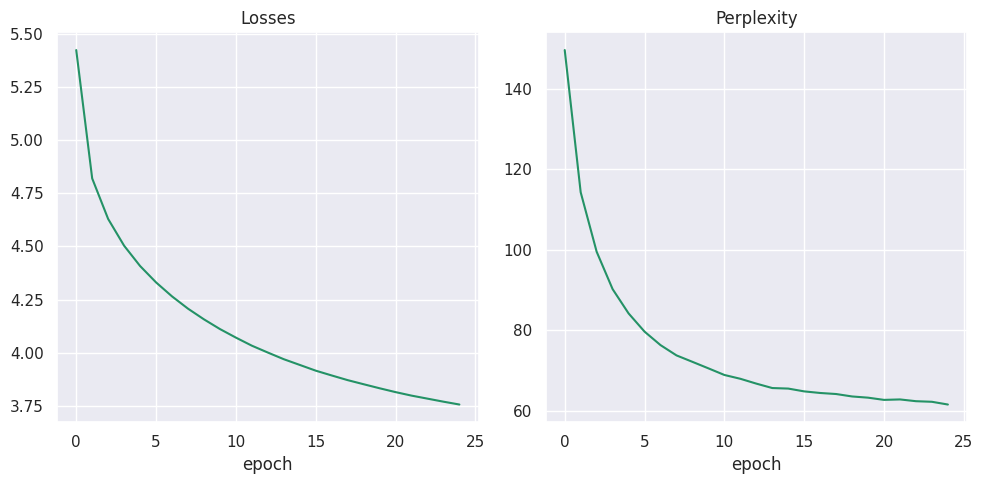

min perplexities: 61.59765459549166


In [ ]:
train_and_plot(model=model, optimizer=optimizer, criterion=criterion,
               train_dataloader=train_dataloader, eval_dataloader=eval_dataloader,
               num_epoch=25)


In [ ]:
generate_some_examples(model)


First few words: ['This', 'film', 'is']
	 <bos> This film is a very good film , but it 's not worth watching . <eos>
First few words: ['It', 'was']
	 <bos> It was a great film for me . <eos>
First few words: ['The', 'relationship', 'between']
	 <bos> The relationship between the characters , and the characters are very believable . <eos>


перплексия стала похуже, но предложения стали в целом лучше в тч 3й пример

#### Добавим нейронов

In [ ]:
class GRU_LM(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, input_batch) -> torch.Tensor:
        '''
        [batch_size, seq_len, hidden_dim]
        [batch_size, seq_len, hidden_dim]
        [batch_size, seq_len, hidden_dim]
        [batch_size, seq_len, vocab_size]
        '''
        embeddings = self.embedding(input_batch)
        output, _ = self.rnn(embeddings)
        output = self.dropout(self.linear(self.non_lin(output)))
        projection = self.projection(self.non_lin(output))

        return projection

In [ ]:
model = GRU_LM(hidden_dim=256*2, vocab_size=len(vocab)).to(device) # <------- main difference 256*2
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

Training epoch 0::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 10::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 11::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 12::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 13::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 14::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 15::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 16::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 17::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 18::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 19::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 20::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 21::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 22::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 23::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 24::   0%|          | 0/1243 [00:00<?, ?it/s]

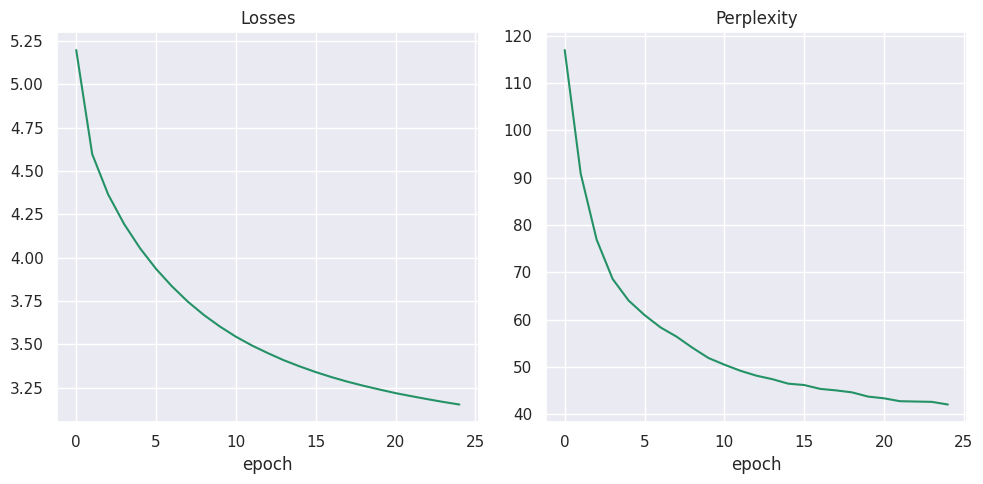

min perplexities: 42.01539600033558


In [ ]:
train_and_plot(model=model, optimizer=optimizer, criterion=criterion,
               train_dataloader=train_dataloader, eval_dataloader=eval_dataloader,
               num_epoch=25)


In [ ]:
generate_some_examples(model)


First few words: ['This', 'film', 'is']
	 <bos> This film is about a troubled family life . <eos>
First few words: ['It', 'was']
	 <bos> It was n't that bad , but it was n't that bad . <eos>
First few words: ['The', 'relationship', 'between']
	 <bos> The relationship between the two main characters is excellent . <eos>


перплексия стала лучше и предлажения стали немного сложнее, но появаился косяк во втором примере с раздельным написанием was n't.  
В общем качество стало лучше

#### Теперь я хочу ичпользовать лстм с теми же параметрами

In [ ]:
class LSTM_LM(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, batch_first=True) # <--------- changed
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, input_batch) -> torch.Tensor:
        '''
        [batch_size, seq_len, hidden_dim]
        [batch_size, seq_len, hidden_dim]
        [batch_size, seq_len, hidden_dim]
        [batch_size, seq_len, vocab_size]
        '''
        embeddings = self.embedding(input_batch)
        output, _ = self.rnn(embeddings)
        output = self.dropout(self.linear(self.non_lin(output)))
        projection = self.projection(self.non_lin(output))

        return projection

In [ ]:
model = LSTM_LM(hidden_dim=256*2, vocab_size=len(vocab)).to(device) # <------- 256*2
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

Training epoch 0::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 10::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 11::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 12::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 13::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 14::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 15::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 16::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 17::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 18::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 19::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 20::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 21::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 22::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 23::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 24::   0%|          | 0/1243 [00:00<?, ?it/s]

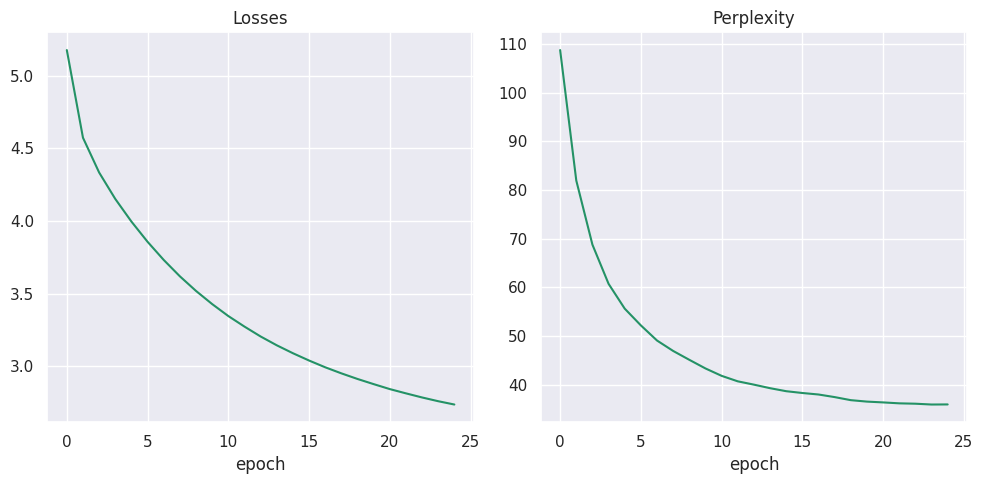

min perplexities: 35.97493208513297


In [ ]:
train_and_plot(model=model, optimizer=optimizer, criterion=criterion,
               train_dataloader=train_dataloader, eval_dataloader=eval_dataloader,
               num_epoch=25)


In [ ]:
generate_some_examples(model)


First few words: ['This', 'film', 'is']
	 <bos> This film is a must see for all ages . <eos>
First few words: ['It', 'was']
	 <bos> It was n't that bad , but it was n't . <eos>
First few words: ['The', 'relationship', 'between']
	 <bos> The relationship between <unk> and McCormick is very well done . <eos>


значение перплексии стало еще меньше, но как мне кажется, качество генерируемго текста стало хуже

#### Теперь сделаем Dropout=0.1

In [27]:
class LSTM_LM(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, batch_first=True) # <--------- changed
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)# <--------- changed

    def forward(self, input_batch) -> torch.Tensor:
        '''
        [batch_size, seq_len, hidden_dim]
        [batch_size, seq_len, hidden_dim]
        [batch_size, seq_len, hidden_dim]
        [batch_size, seq_len, vocab_size]
        '''
        embeddings = self.embedding(input_batch)
        output, _ = self.rnn(embeddings)
        output = self.dropout(self.linear(self.non_lin(output)))
        projection = self.projection(self.non_lin(output))

        return projection

In [28]:
model = LSTM_LM(hidden_dim=256*2, vocab_size=len(vocab)).to(device) # <------- 256*2
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

Training epoch 0::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 10::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 11::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 12::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 13::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 14::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 15::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 16::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 17::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 18::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 19::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 20::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 21::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 22::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 23::   0%|          | 0/1243 [00:00<?, ?it/s]

Training epoch 24::   0%|          | 0/1243 [00:00<?, ?it/s]

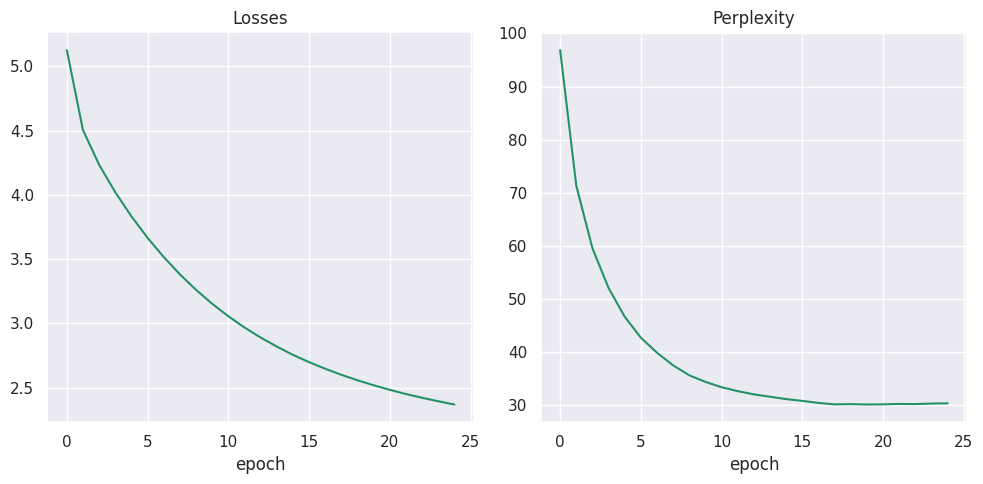

min perplexities: 30.132099222799372


In [29]:
train_and_plot(model=model, optimizer=optimizer, criterion=criterion,
               train_dataloader=train_dataloader, eval_dataloader=eval_dataloader,
               num_epoch=25)


In [30]:
generate_some_examples(model)


First few words: ['This', 'film', 'is']
	 <bos> This film is not a bad movie . <eos>
First few words: ['It', 'was']
	 <bos> It was a great film to watch , but it was n't . <eos>
First few words: ['The', 'relationship', 'between']
	 <bos> The relationship between <unk> and <unk> is a fantastic film that is n't as good as BSG , is a masterpiece . <eos>


перплексия стала еще меньше, но качество примеров, как мне кажется упало. Они стали сложнее по структуре, но по наплнению стали хуже

### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.

В таблице представлены названия моделей, качество оценки примеров(я выставлял отталкиваясь только от своего мнения по 10ти бальной шкале) и перплексия


<html>
 <head>
  <meta charset="utf-8">
 </head>
 <body>
  <table border="1">
   <tr>
    <th>Model name</th>
    <th>качество примера №1</th>
    <th>качество примера №2</th>
    <th>качество примера №3</th>
    <th>perplexity</th>
   </tr>
   <tr>
    <td>Basic GRU</td>
    <td>6</td>
    <td>6</td>
    <td>3</td>
    <td>49</td>
  </tr>

  <tr>
    <td>GRU_Dropout=0.3</td>
    <td>6.5</td>
    <td>6.5</td>
    <td>5</td>
    <td>61.59</td>
  </tr>

  <tr>
    <td>GRU_Dropout=0.3_512</td>
    <td>7</td>
    <td>6</td>
    <td>5</td>
    <td>42</td>
  </tr>

  <tr>
    <td>LSTM_Dropout=0.3_512</td>
    <td>7</td>
    <td>6</td>
    <td>5</td>
    <td>35.9</td>
  </tr>

  <tr>
    <td>LSTM_Dropout=0.1_512</td>
    <td>5</td>
    <td>5</td>
    <td>5</td>
    <td>30.13</td>
  </tr>
  
 </table>
 </body>
</html>

Наименьшая перплексия оказалась у последней модели(LSTM_Dropout=0.1_512), но лучшая по моему мнению получилась GRU_Dropout=0.3_512

Как улучшить?  
* больше данных
* больше эпох/слоев/нейронов
* Можно было бы попытаться научить другую nn отделять сгенерированные тексты от реальных и добавить это в функцию потерь первой модели, что бы улучшить качество генерируемых данных (что-то на подобии ГАН'ов)